<a href="https://colab.research.google.com/github/akankshakusf/Project-Fine-Tuned-LLMs-for-Product-Pricing/blob/master/QLora_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict Product Prices - QLora Hyperparmeter Tuning

reference : https://medium.com/@dataoilst.info/breakdown-of-hugging-face-peft-776539e45231

In [ ]:
# pip installs
!pip install -q datasets \
                requests \
                torch \
                peft \
                bitsandbytes \
                transformers \
                trl \
                accelerate \
                sentencepiece\
                tiktoken \
                matplotlib \
                wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#import packages
import os
import re
import tqdm
import math
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,\
                                  TrainingArguments, set_seed
from peft import LoraConfig
import wandb
from trl import SFTTrainer, SFTConfig ##(Xmer RFL) trainer library from hugging face
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Constants
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "akankshakusf"

#my dataset from hugging face
DATASET_NAME =  f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182

#run name for saving the model to the hub
RUN_NAME =f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME=f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

#Hyperparameters for QLoRA tuning
LORA_R = 32
LORA_ALPHA = 64  ###double of R
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

#other Hyperparameter for training
EPOCHS = 3 #1
BATCH_SIZE=16 ### on an A100 box this can go up to 16 or ## 4
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = "cosine"
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

##note that SAVE_STEPS is how often it will upload to the hub
##I've changed this from 5000 to 2000 so that you get more frequent saves

STEPS = 50  ##loss punched after every 50 steps
SAVE_STEPS = 2000  ##after 2000 steps saves model to hugging face
LOG_TO_WANDB = True

%matplotlib inline

In [ ]:
HUB_MODEL_NAME

'akankshakusf/pricer-2025-05-02_20.00.01'

- Reference :https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one#optimizer-choice

The most common is Adam or AdamW (Adam with Weight Decay).  
Adam achieves good convergence by storing the rolling average of the previous gradients; however, it adds an additional memory footprint of the order of the number of model parameters.

In [ ]:
#Log in to HuggingFace
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
# Log in to Weights & Biases
wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Currently logged in as: akushwaha2 (akankshakusf2) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
#load my dataset from hugging face
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nStar Micronics USB Thermal Receipt Printer with Device and Mfi USB Ports, Auto-cutter, and Internal Power Supply - Gray (Renewed)\nHigh-speed printing of 43 receipts per minute with easy to setup USB connection - just Plug and Print; USB serial number feature means the PC will detect the on its Windows platform using any USB port Includes PromoPRNT promotion printing service allowing you to automatically create printed promotions in addition to receipts Drop-In and Print clamshell design allows for fast and easy paper loading; patented De-Curl function always delivers a flat receipt futurePRNT Software allows you to customize receipts to keep customers coming back time and time again with professional graphics (logos, coupons), word-triggered advertising, and more The small footprint and embedded power supply saves precious counter space Brand Star Mic\n\nPrice is $207.00',
 'price': 207.0}

In [ ]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

## Load the Tokenizer and Model

In [ ]:
# pick the right quantization
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

# Data Collator :

*got it handy from hugging face*
- refrence : https://huggingface.co/docs/trl/v0.9.6/en/sft_trainer#advanced-usage

- The trainer needs to teach the model to predict the token(s) after "Price is $".

- There is a complicated way to do this by setting Masks, but luckily HuggingFace provides a super simple helper class to take care of this for us.

In [ ]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

# Set up the configuration for Training


We need to create 2 objects:

- A LoraConfig object with our hyperparameters for LoRA

- An SFTConfig with our overall Training parameters-

- Reference: https://medium.com/@dataoilst.info/breakdown-of-hugging-face-peft-776539e45231

In [ ]:
# First, specify the configuration parameters for LoRA
# call everything here define above
lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training
# call everything here define above
train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters
# The latest version of trl is showing a warning about labels - please ignore this warning
# But let me know if you don't see good training results (loss coming down).

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    args=train_parameters,
    data_collator=collator
  )

# Kick off Fine Tuning

In [ ]:
# Fine-tune!
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


Step,Training Loss
50,2.846700
100,2.264300
150,1.950300
200,1.915400
250,1.904300
300,1.889200
350,1.901900
400,1.897800
450,1.876800
500,1.848300


/usr/local/lib/python3.11/dist-packages/trl/trainer/utils.py:150: UserWarning: Could not find response key `Price is $` in the following instance: <|begin_of_text|>How much does this cost to the nearest dollar?

LCL Compatible Toner Cartridge Replacement for Dell M11XH C3NTP B2360D 8500 Pages Black)
𝐏𝐮𝐫𝐜𝐡𝐚𝐬𝐞 𝐍𝐨𝐭𝐞𝐬 For your convenience, before purchasing please refer to the Product Description as below 𝐂𝐨𝐦𝐩𝐚𝐭𝐢𝐛𝐥𝐞 𝐏𝐫𝐢𝐧𝐭𝐞𝐫𝐬 Replacement for Dell B2360d 𝐇𝐢𝐠𝐡 𝐂𝐚𝐩𝐚𝐜𝐢�. This instance will be ignored in loss calculation. Note, if this happens often, consider increasing the `max_length`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/utils.py:150: UserWarning: Could not find response key `Price is $` in the following instance: <|begin_of_text|>How much does this cost to the nearest dollar?

Waterdrop Filter, Replacement for Reverse Osmosis System, 2-year Lifetime
𝐂𝐨𝐦𝐩𝐚𝐭𝐢𝐛𝐥𝐞 𝐦𝐨𝐝𝐞𝐥 Waterdrop Reverse Osmosis System. 𝐋𝐨𝐧𝐠 𝐬𝐞𝐫𝐯𝐢𝐜𝐞 𝐥𝐢𝐟𝐞 This water filter provides you with 24 mont

In [ ]:
#stop wandb
if LOG_TO_WANDB:
  wandb.finish()

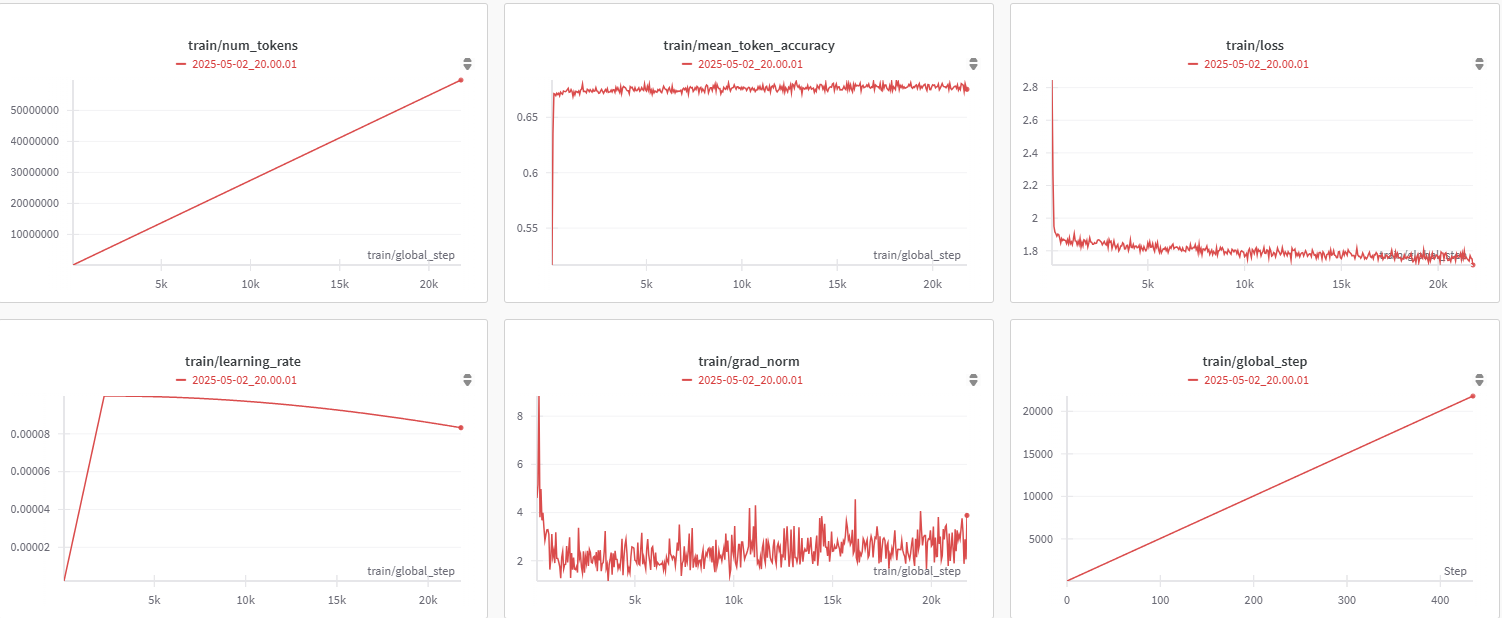